In [173]:
from analysis import sns, COLORS, BEAM_COLORS, COLORS_C
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from mongoengine import connect
from pybirales.repository.models import SpaceDebrisTrack
from scipy.stats.stats import pearsonr
from numpy.linalg import lstsq

import os

In [174]:
db_connection = connect(
    db='birales',
    username='birales_rw',
    password='arcadia10',
    port=27017,
    host='localhost')

In [175]:
OUT_DIR = "/home/denis/.birales/visualisation/analysis"
ROOT = "/home/denis/.birales/visualisation/fits/30774"

OBSERVATION_ID = "5b77f8a0be045a6eb32256c3" # NORAD_4071 (id = 4)
TRACK_ID = 4
TRACK_NAME = 'norad_4071'

# OBSERVATION_ID = "5b784f1fbe045a2044a9de63" # NORAD_37820 (Tiangong1) (id = 0)
# TRACK_ID = 0
# TRACK_NAME = 'tiangong'

# OBSERVATION_ID = "5b78532bbe045a22abe3596f" # NORAD_20439 (id = 1)
# TRACK_ID = 1
# TRACK_NAME = 'norad_20439'

detected_candidates = SpaceDebrisTrack.get(observation_id=OBSERVATION_ID)

for c in detected_candidates:
    print len(c.data['snr'])
    
SAVE_FIGURES = False


13
9
7
92
9333
11


In [176]:
if not detected_candidates:
    print('No detection tracks in observation', observation_id)

# Get the track in the observation by TRACK_ID
track = detected_candidates[TRACK_ID]
TX = track.tx
df = pd.DataFrame(track.data)
# Calculate doppler shift
df['doppler'] = (df['channel'] - TX) * 1e6
df['Beam'] =  df['beam_id']
df['beam_id'] = df['beam_id'].astype(int)
df=df.sort_values(by=['time_sample'])

print('Track size: {}'.format(df.shape))

def out_file(filename):
    return os.path.join(OUT_DIR,'{}_{}.pdf'.format(TRACK_NAME, filename))

Track size: (9333, 8)


In [177]:
# Preview the data
df.head()

,beam_id,channel,channel_sample,snr,time,time_sample,doppler,Beam
0,23,410.083445,1110,5.512046,2018-03-29 07:28:43.567,890,-1555.404663,23
1,11,410.083445,1110,4.921314,2018-03-29 07:28:43.567,890,-1555.404663,11
2,0,410.083445,1110,6.031139,2018-03-29 07:28:43.567,890,-1555.404663,0
17,23,410.083416,1107,16.371021,2018-03-29 07:28:43.672,891,-1584.014893,23
16,15,410.083426,1108,7.604159,2018-03-29 07:28:43.672,891,-1574.478149,15


In [178]:
df.describe()

,beam_id,channel,channel_sample,snr,time_sample,doppler,Beam
count,9333.000000,9333.000000,9333.000000,9333.000000,9333.000000,9333.000000,9333.000000
mean,15.191793,410.082152,974.424944,10.394665,973.583307,-2848.349154,15.191793
std,8.941089,0.000590,61.902746,4.569058,38.649904,590.350587,8.941089
min,0.000000,410.080603,812.000000,4.459759,890.000000,-4397.354126,0.000000
25%,7.000000,410.081690,926.000000,6.655733,944.000000,-3310.165405,7.000000
50%,15.000000,410.082157,975.000000,9.531320,973.000000,-2842.864990,15.000000
75%,23.000000,410.082605,1022.000000,13.165016,1004.000000,-2394.638062,23.000000
max,31.000000,410.083445,1110.000000,28.745370,1076.000000,-1555.404663,31.000000


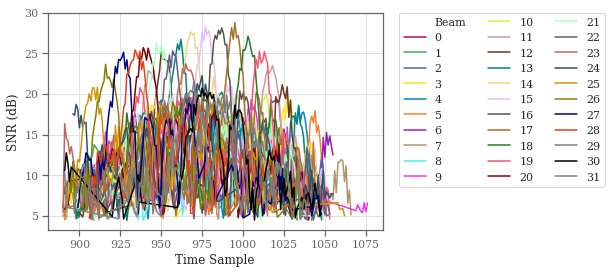

In [179]:
# Figure 1. Power against time for each beam

# Process the data. Select highest SNR in time, and channel (within the beam)
df = df.sort_values('snr', ascending=False).drop_duplicates(subset=['time_sample', 'beam_id']).sort_values(by=['beam_id'])
df = df.sort_values('snr', ascending=False).drop_duplicates(subset=['channel_sample', 'beam_id']).sort_values(by=['beam_id'])


ax1 = sns.lineplot(y="snr", x="time_sample", data=df,estimator=None, ci=None, hue=df['Beam']
                   , sort=True, palette=BEAM_COLORS)
ax1.set(xlabel='Time Sample', ylabel='SNR (dB)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=3)

if SAVE_FIGURES:
    plt.savefig(out_file('p_t'), bbox_inches='tight')

In [180]:
df1 = df.copy()

print ('Track was detected across the following beams: {}'.format(df['beam_id'].unique()))

# Process the data. Select highest SNR in time (within the beam)
df1 = df1.sort_values('snr', ascending=False).drop_duplicates(subset=['time_sample']).sort_values(by=['time_sample'])

print ('Track reduced to {} from {} pixels after SNR/Time duplicate filter'.format(len(df1), len(df)))

# Process the data. Select highest SNR in channel (within the beam)
df1 = df1.sort_values('snr', ascending=False).drop_duplicates(subset=['channel_sample']).sort_values(by=['time_sample'])

print ('Track reduced to {} from {} pixels after SNR/Channel duplicate filter'.format(len(df1), len(df)))

Track was detected across the following beams: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Track reduced to 184 from 3732 pixels after SNR/Time duplicate filter
Track reduced to 184 from 3732 pixels after SNR/Channel duplicate filter


[ 0 23 24 25 26 27 28 20 21 12 22 13 14 15 16 17 18 19 11  3  4  5  6  7
  9]


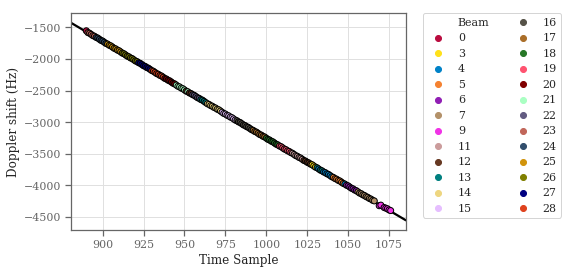

In [181]:
# Figure 2. Doppler shift against time for each beam

ax0 = sns.scatterplot(y="doppler", x="time_sample", data=df1, hue='Beam', 
                      estimator=None, linewidth=1, palette=BEAM_COLORS, 
                      edgecolor='black', zorder=2);
ax0 = sns.regplot(y="doppler", x="time_sample", data=df1, scatter=False,
                 fit_reg=True,  line_kws={'color': 'black', 'zorder':1})
ax0.set(xlabel='Time Sample', ylabel='Doppler shift (Hz)')
print(df1['beam_id'].unique())

ncol = 2 if len(df1['beam_id'].unique()) > 12 else 1
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=ncol)
# plt.plot(df1['time_sample'], df1['doppler'], zorder=1)

if SAVE_FIGURES:
    plt.savefig(out_file('d_t'), bbox_inches='tight')    

Track reduced to 25 from pixels after SNR/beam duplicate filter
Beam illumination sequence is: [ 0 23 24 25 26 27 28 20 21 12 22 13 14 15 16 17 18 19 11  3  4  5  6  7
  9]


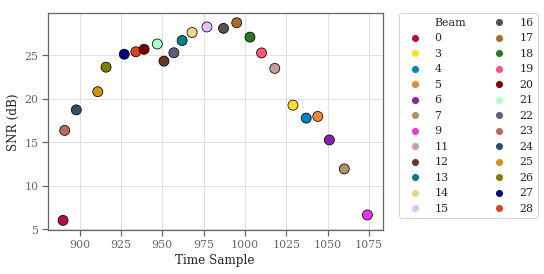

In [182]:
# Figure 4. Beam illumination sequence. 
# Process the data. Select highest SNR in time (within the beam)
df2 = df1.copy()

# Process the data. Select highest SNR in time (within the beam)
df2 = df2.sort_values('snr', ascending=False).drop_duplicates(subset=['beam_id']).sort_values(by=['time_sample'])
print ('Track reduced to {} from pixels after SNR/beam duplicate filter'.format(len(df2), len(df1)))
print ('Beam illumination sequence is: {}'.format(df2['beam_id'].unique()))

# Plot
ax3 = sns.scatterplot(y="snr", x="time_sample", hue='Beam', data=df2, palette=BEAM_COLORS, s=100, edgecolor='black')
ax3.set(xlabel='Time Sample', ylabel='SNR (dB)')
plt.rcParams["axes.edgecolor"] = "#666666"
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=ncol)

if SAVE_FIGURES:
    plt.savefig(out_file('p_t_max'), bbox_inches='tight')   

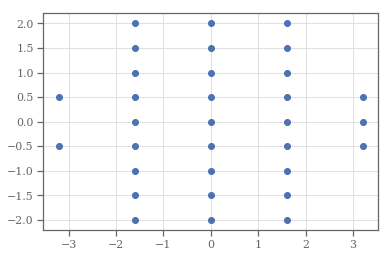

In [183]:
# Adding pointing information to the beams
pointings = np.array(track.pointings['ra_dec'])
ra_poinings = pointings[:, 0]
dec_poinings = pointings[:, 1]

df2['dec'] = dec_poinings[df2['beam_id']]
df2['ra'] = ra_poinings[df2['beam_id']]

df3 = df2.copy()

plt.scatter(ra_poinings, dec_poinings)

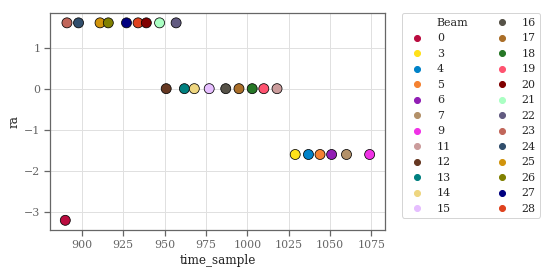

In [184]:
# Figure 5: Trajectory RA v. time
ax4 = sns.scatterplot(y="ra", x="time_sample", hue='Beam', data=df3, palette=BEAM_COLORS, s=100, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=ncol)

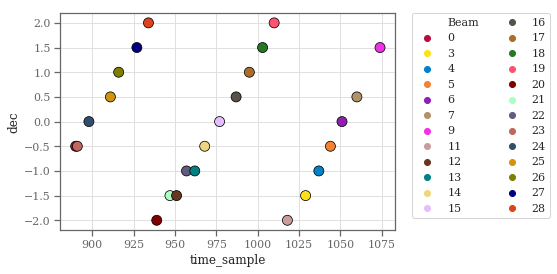

In [185]:
# Figure 6: Trajectory DEC v. time
ax5 = sns.scatterplot(y="dec", x="time_sample", hue='Beam', data=df3, palette=BEAM_COLORS, s=100, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=ncol)


[ 0 23 24 25 26 27 28 20 21 12 22 13 14 15 16 17 18 19 11  3  4  5  6  7
  9]


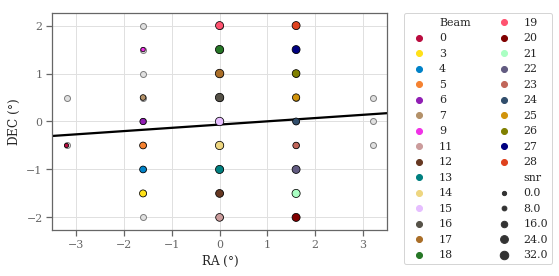

In [186]:
plt.xlim(-3.5,3.5)
ax6 = sns.scatterplot(y="dec", x="ra", hue='Beam', data=df3, palette=BEAM_COLORS, size='snr'
                      , edgecolor='black',zorder=110)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=ncol)
ax6 = sns.regplot(x='ra', y='dec', data=df3, scatter=False, color='black', ci=False)
plt.scatter(ra_poinings, dec_poinings, color='#e0e0e0', zorder=10, edgecolor='gray')
ax6.set(xlabel='RA ($\degree$)', ylabel='DEC ($\degree$)')
print df2['beam_id'].unique()

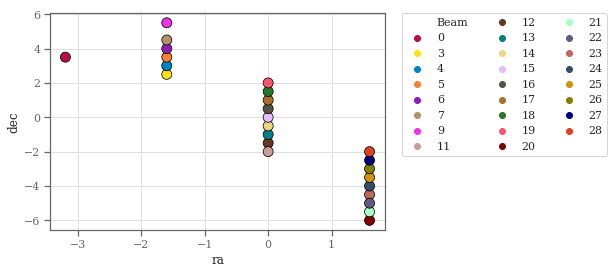

In [187]:
# Figure 7: Trajectory RA/DEC
# To be compared with real trajectory of the space debris
df4 = df3.copy()

df4.loc[df4['ra'] < 0, 'dec'] += 4
df4.loc[df4['ra'] > 0, 'dec'] -= 4

ax6 = sns.scatterplot(y="dec", x="ra", hue='Beam', data=df4, palette=BEAM_COLORS, s=100, edgecolor='black')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=3)

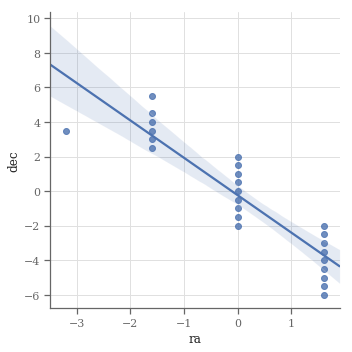

In [188]:
# Trajectory
ax7 =sns.lmplot(x='ra', y='dec', data=df4)